In [1]:
from abc import ABC, abstractmethod
from typing import Dict, List, Optional, Union, Tuple

import plotly
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt


In [23]:
class AmmortizationSchedule:

    def __init__(self, n: int, debt: float, rate: float) -> None:
        """
        Args:
            n (int): Number of periods (total number of payments).
            debt (float): Present value or principal (loan amount).
            rate (float): Interest rate per period (e.g., monthly interest rate).
        """

        self.n = n
        self.debt = debt
        self.rate = rate
        self.payment = self._calculate_payment(n=self.n, debt=self.debt, rate=self.rate)

        self.schedule: pd.DataFrame = self._calculate_ammortization_schedule() 

        return
    
    @staticmethod
    def _calculate_interest(debt: float, rate: float) -> float:
        return debt * rate
    
    @staticmethod
    def _calculate_principal(payment: float, interest: float) -> float:
        return payment - interest
    
    @staticmethod
    def _calculate_debt(debt: float, principal: float) -> float:
        return debt - principal
    
    @staticmethod
    def _calculate_equity(equity: float, principal: float) -> float:
        return equity + principal
    
    @staticmethod
    def _calculate_payment(n: int, debt: float, rate: float) -> float:
        """
        Computes the periodic payment that accounts for principal, interest, and compunding.
        """

        if rate == 0.0:
            
            # If zero interest rate, return equally divied payments of the outstanding debt
            return debt / n
        
        else:

            # Scale periodic interest on outstanding debt by a discount rate that accounts for compounding  
            return (debt * rate) / (1 - 1 / (1 + rate) ** n)
    
    def _calculate_ammortization_schedule(self) -> pd.DataFrame:
        
        equity: float = 0.0
        debt: float = self.debt
        
        schedule: Dict[int, Dict[str, float]] = {}

        for t in range(self.n):

            schedule[t] = {}
            
            schedule[t]["payment"] = self.payment
            schedule[t]["interest"] = self._calculate_interest(rate=self.rate, debt=debt)
            schedule[t]["principal"] = self._calculate_principal(payment=self.payment, interest=schedule[t]["interest"]) 

            debt = self._calculate_debt(debt=debt, principal=schedule[t]["principal"])
            equity = self._calculate_equity(equity=equity, principal=schedule[t]["principal"])
            
            schedule[t]["debt"] = debt
            schedule[t]["equity"] = equity

        return pd.DataFrame(schedule).T 

    def plot(self) -> None:
        
        self.schedule[["debt", "equity"]].plot(title="Debt vs. Equity Schedule")      
        self.schedule[["interest", "principal", "payment"]].plot(title="Ammortization Schedule")
        
        return


class RandomVariable(ABC):

    @abstractmethod
    def simulate(self, shape: Optional[Tuple[int, int]] = None) -> float:
        """
        Simulates a variable.
        """
        raise NotImplementedError


class NormalRandomVariable(RandomVariable):

    def __init__(self, mu: float, sigma: Optional[float] = None) -> None:

        self.mu = mu
        self.sigma = sigma

        return

    def simulate(self, shape: Optional[Tuple[int, int]] = None) -> float:
        """
        Simulates a normally distributed variable or a constant if no sigma (i.e., scale or standard deviation) is defined.
        """
        return np.random.normal(loc=self.mu, scale=self.sigma, size=shape) if self.sigma else self.mu


class LogNormalRandomVariable:

    def __init__(self, mu: float, sigma: Optional[float] = None) -> None:

        self.mu = mu
        self.sigma = sigma

        return

    def simulate(self, shape: Optional[Tuple[int, int]] = None) -> float:
        """
        Simulates a log-normally distributed variable or a constant if no sigma (i.e., scale or standard deviation) is defined.
        """
        return np.exp(np.random.normal(loc=self.mu - 0.5 * self.sigma ** 2, scale=self.sigma, size=shape)) - 1 if self.sigma else self.mu


class BoundedNormalRandomVariable(RandomVariable):

    def __init__(self, mu: float, sigma: float, lower_bound: float, upper_bound: float) -> None:

        self.mu = mu
        self.sigma = sigma
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound

        return

    def simulate(self, shape: Optional[Tuple[int, int]] = None) -> float:
        """
        Simulates a bounded normally distributed variable or a constant if no sigma (i.e., scale or standard deviation) is defined.
        """

        random_variable = np.random.normal(loc=self.mu, scale=self.sigma, size=shape)

        if shape:
           
            # While there are values outside of the bounds, regenerate only those values
            out_of_bounds = (random_variable <= self.lower_bound) | (random_variable >= self.upper_bound)
            
            while np.any(out_of_bounds):
                
                # Re-sample only the out-of-bound elements
                random_variable[out_of_bounds] = np.random.normal(loc=self.mu, scale=self.sigma, size=np.sum(out_of_bounds))
                
                # Update out-of-bound entries
                out_of_bounds = (random_variable <= self.lower_bound) | (random_variable >= self.upper_bound)
        
        else:

            # If the random variable is out-of-bounds, recursively re-sample
            if self.lower_bound <= random_variable <= self.upper_bound:
                random_variable = self.simulate(shape=shape)
        
        return random_variable


class UniformRandomVariable(RandomVariable):

    def __init__(self, lower_bound: float, upper_bound: float) -> None:

        self.lower_bound = lower_bound
        self.upper_bound = upper_bound

        return

    def simulate(self, shape: Optional[Tuple[int, int]] = None) -> float:
        """
        Simulates a uniformly distributed variable.
        """
        return np.random.uniform(low=self.lower_bound, high=self.upper_bound, size=shape)


class IndicatorRandomVariable(RandomVariable):

    def __init__(self, probability: float) -> None:

        self.probability = probability

        return

    def simulate(self, shape: Optional[Tuple[int, int]] = None) -> float:
        """
        Simulates an indicator random variables for a given probability.
        """
        return np.random.choice(a=[0, 1], p=[1 - self.probability, self.probability], size=shape)


class RevenueModel:

    def __call__(self, rent: float, occupancy_rate: float) -> float:
        """
        TODO: create time varying paths of rents, occupancy_rate, etc.

        Args:
            rent (float): Expected monthly rent.
            occupancy_rate (float): Expected occupancy rate as a fraction.
        """
        return rent * occupancy_rate 


class TaxBenefitModel:

    def __call__(self, n: int, interest_expense: float, property_value: float) -> float:
        """
        TODO: determine the true calculation - this is a rough proxy for now.
        """

        uncertainty_discount_factor = 0.5
        depreciation_deduction = property_value / n
        interest_deduction = interest_expense * 0.3
        property_tax_deduction = min(10_000, property_value * 0.02 / 12)
        
        return 0   # interest_deduction + depreciation_deduction * uncertainty_discount_factor + property_tax_deduction


class ExpenseModel:

    def __call__(
            self,  
            utility_expense: float, 
            interest_expense: float,
            insurance_expense: float,
            maintenance_expense: float,
            property_tax_expense: float,
            miscellaneous_expense: float
    ) -> float:
                
        return (
            utility_expense +
            interest_expense + 
            insurance_expense + 
            maintenance_expense + 
            property_tax_expense + 
            miscellaneous_expense
        )


class MonteCarloSimulator:
    """
    TODO: account for growth rates of random variables.
    TODO: account for cap rate.
    TODO: account for NOI.
    TODO: account for a valuation model = NOI / cap rate.
    TODO: account for levered and unlevered IRR.
    TODO: account for my cash flow / return on 1) equity 2) my true return which really captures what equity + cash flow I get for my initial investment + periodic cash flow injections.
    """

    def __init__(
            self,
            n: int,
            debt: float,
            rate: float,
            rent: float,
            equity: float,
            n_simulations: int,
            expense_model: ExpenseModel,
            revenue_model: RevenueModel,
            tax_benefit_model: TaxBenefitModel,
            occupancy_rate: RandomVariable,
            utility_expense: RandomVariable,
            insurance_expense: RandomVariable,
            maintenance_expense: RandomVariable,
            property_tax_expense: RandomVariable,
            miscellaneous_expense: RandomVariable
    ) -> None:
        
        self.n = n
        self.debt = debt
        self.rate = rate
        self.rent = rent
        self.equity = equity
        self.n_simulations = n_simulations
        self.expense_model = expense_model
        self.revenue_model = revenue_model
        self.tax_benefit_model = tax_benefit_model
        self.occupancy_rate = occupancy_rate        
        self.utility_expense = utility_expense
        self.insurance_expense = insurance_expense
        self.maintenance_expense = maintenance_expense
        self.property_tax_expense = property_tax_expense
        self.miscellaneous_expense = miscellaneous_expense

        self.shape: Tuple[int, int] = (self.n, self.n_simulations)
        self.property_value: float = self.debt + self.equity
        self.ammortization_schedule = AmmortizationSchedule(n=self.n, debt=self.debt, rate=self.rate)

        self.revenue_simulation: Optional[Union[np.ndarray, pd.DataFrame]] = None
        self.expense_simulation: Optional[Union[np.ndarray, pd.DataFrame]] = None
        self.cash_flow_simulation: Optional[Union[np.ndarray, pd.DataFrame]] = None
        self.tax_benefit_simulation: Optional[Union[np.ndarray, pd.DataFrame]] = None
        
        return
    
    def _simulate(self) -> Tuple[float, float, float]:
        """
        Capture 

        Returns:
            Tuple[float, float, float]: _description_
        """

        revenue: Union[float, np.ndarray] = self.revenue_model(rent=self.rent, occupancy_rate=self.occupancy_rate.simulate(shape=self.shape))

        tax_benefit: Union[float, np.ndarray] = np.zeros(shape=self.shape) + 100.0  # TODO: implement this in a vectorized manner - self.tax_benefit_model(n=self.n, interest_expense=interest_expense, property_value=self.property_value)
        
        interest_expense: np.ndarray = np.reshape(np.array(self.ammortization_schedule.schedule["interest"]), newshape=(-1, 1))

        expenses: Union[float, np.ndarray] = self.expense_model(
            interest_expense=interest_expense,
            utility_expense=self.utility_expense.simulate(shape=self.shape),
            insurance_expense=self.insurance_expense.simulate(shape=self.shape), 
            maintenance_expense=self.maintenance_expense.simulate(shape=self.shape),
            property_tax_expense=self.property_tax_expense.simulate(shape=self.shape),
            miscellaneous_expense=self.miscellaneous_expense.simulate(shape=self.shape)
        )

        cash_flow: np.ndarray = revenue + tax_benefit - expenses

        return revenue, tax_benefit, expenses, cash_flow

    def run(self) -> pd.DataFrame:

        self.revenue_simulation, self.tax_benefit_simulation, self.expense_simulation, self.cash_flow_simulation = self._simulate()

        self.revenue_simulation = pd.DataFrame(self.revenue_simulation)
        self.expense_simulation = pd.DataFrame(self.expense_simulation)
        self.cash_flow_simulation = pd.DataFrame(self.cash_flow_simulation) 
        self.tax_benefit_simulation = pd.DataFrame(self.tax_benefit_simulation)
        
        return
    
    def analyze(self) -> None:
        """
        Analyze the results of the Monte Carlo simulation, such as expected profit/loss.
        """

        if self.cash_flow_simulation is None:
            self.run()
            
        cumulative_cash_flows = np.sum(self.cash_flow_simulation, axis=0)
        
        print(f"Terminal Cash Flow Mean: {cumulative_cash_flows.mean()}")
        print(f"Terminal Cash Flow Min: {cumulative_cash_flows.min()}")
        print(f"Terminal Cash Flow Max: {cumulative_cash_flows.max()}")
        print(f"Periodic Cash Flow Mean: {np.mean(self.cash_flow_simulation)}")
        print(f"Periodic Cash Flow Standard Deviation: {np.std(self.cash_flow_simulation.to_numpy().flatten(), ddof=1)}")
        print(f"Cash Flow Mean Sharpe Ratio: {np.mean(self.cash_flow_simulation) / np.std(self.cash_flow_simulation.to_numpy().flatten(), ddof=1)}")
        
        self.cash_flow_simulation.plot(title="Periodic Cash Flows", legend=False)
        self.cash_flow_simulation.plot(kind="hist", title="Periodic Cash Flows", legend=False)
        self.cash_flow_simulation.cumsum().plot(title="Cumulative Cash Flows", legend=False)

        self.revenue_simulation.plot(kind="hist", title="Periodic Revenue", legend=False)
        self.expense_simulation.plot(kind="hist", title="Periodic Expenses", legend=False)
        self.expense_simulation.plot(title="Periodic Expenses", legend=False)
        self.tax_benefit_simulation.plot(title="Periodic Tax Benefit", legend=False)

        return

In [33]:
N_SIMULATIONS: int = 1_000
N_PAYMENTS_PER_PERIOD: int = 12 
N: int = 30 * N_PAYMENTS_PER_PERIOD
RATE: float = 0.065 / N_PAYMENTS_PER_PERIOD

RENT: float = 3_000.0
DEBT: float = 250_000.0
EQUITY: float = 100_000.0

EXPENSE_MODEL: ExpenseModel = ExpenseModel()
REVENUE_MODEL: RevenueModel = RevenueModel()
TAX_BENEFIT_MODEL: TaxBenefitModel = TaxBenefitModel()

PERCENT_TAX_EXPENSE: float = 0.02 / N_PAYMENTS_PER_PERIOD
TAX_EXPENSE_MU: float = PERCENT_TAX_EXPENSE * (DEBT + EQUITY)
TAX_EXPENSE: RandomVariable = NormalRandomVariable(mu=TAX_EXPENSE_MU) 

OCCUPANCY_RATE_PROBABILITY: float = 0.9
OCCUPANCY_RATE: RandomVariable = IndicatorRandomVariable(probability=OCCUPANCY_RATE_PROBABILITY)

UTILITY_EXPENSE_MU: float = 100.0
UTILITY_EXPENSE_SIGMA: float = 20.0
UTILITY_EXPENSE_LOWER_BOUND: float = 50.0
UTILITY_EXPENSE_UPPER_BOUND: float = 200.0
UTILITY_EXPENSE: RandomVariable = BoundedNormalRandomVariable(mu=UTILITY_EXPENSE_MU, sigma=UTILITY_EXPENSE_SIGMA, lower_bound=UTILITY_EXPENSE_LOWER_BOUND, upper_bound=UTILITY_EXPENSE_UPPER_BOUND)

INSURACE_EXPENSE_MU: float = 100.0
INSURACE_EXPENSE_SIGMA: float = 20.0
INSURANCE_EXPENSE_LOWER_BOUND: float = 20.0
INSURANCE_EXPENSE_UPPER_BOUND: float = 200.0
INSURACE_EXPENSE: RandomVariable = BoundedNormalRandomVariable(mu=INSURACE_EXPENSE_MU, sigma=INSURACE_EXPENSE_SIGMA, lower_bound=INSURANCE_EXPENSE_LOWER_BOUND, upper_bound=INSURANCE_EXPENSE_UPPER_BOUND)

MAINTENANCE_EXPENSE_MU: float = 100.0
MAINTENANCE_EXPENSE_SIGMA: float = 20.0
MAINTENANCE_EXPENSE_LOWER_BOUND: float = 20.0
MAINTENANCE_EXPENSE_UPPER_BOUND: float = 200.0
MAINTENANCE_EXPENSE: RandomVariable = BoundedNormalRandomVariable(mu=MAINTENANCE_EXPENSE_MU, sigma=MAINTENANCE_EXPENSE_SIGMA, lower_bound=MAINTENANCE_EXPENSE_LOWER_BOUND, upper_bound=MAINTENANCE_EXPENSE_UPPER_BOUND)

MISCELLANEOUS_EXPENSE_MU: float = 500.0
MISCELLANEOUS_EXPENSE_SIGMA: Optional[float] = 250.0
MISCELLANEOUS_EXPENSE: RandomVariable = BoundedNormalRandomVariable(mu=MISCELLANEOUS_EXPENSE_MU, sigma=MISCELLANEOUS_EXPENSE_SIGMA, lower_bound=0.0, upper_bound=2000.0)

In [34]:
simulation = MonteCarloSimulator(
    n=N,
    debt=DEBT,
    rate=RATE,      
    rent=RENT, 
    equity=EQUITY,
    expense_model=EXPENSE_MODEL,
    revenue_model=REVENUE_MODEL,
    tax_benefit_model=TAX_BENEFIT_MODEL,
    n_simulations=N_SIMULATIONS, 
    property_tax_expense=TAX_EXPENSE,
    occupancy_rate=OCCUPANCY_RATE,      
    utility_expense=UTILITY_EXPENSE, 
    insurance_expense=INSURACE_EXPENSE,
    maintenance_expense=MAINTENANCE_EXPENSE,
    miscellaneous_expense=MISCELLANEOUS_EXPENSE
)

Terminal Cash Flow Mean: 299065.650974527
Terminal Cash Flow Min: 232657.59779451607
Terminal Cash Flow Max: 361982.806277962
Periodic Cash Flow Mean: 830.7379193736862
Periodic Cash Flow Standard Deviation: 989.9842797353671
Cash Flow Mean Sharpe Ratio: 0.8391425362792133


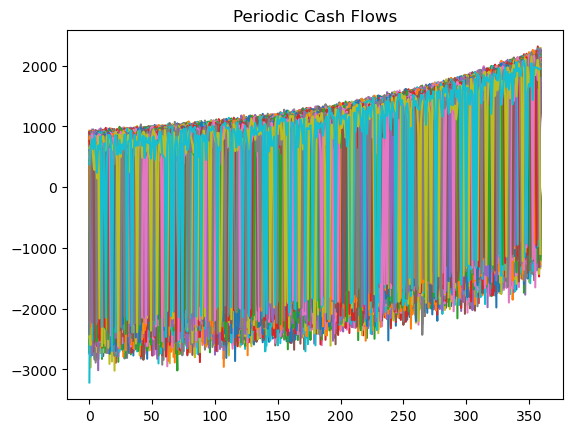

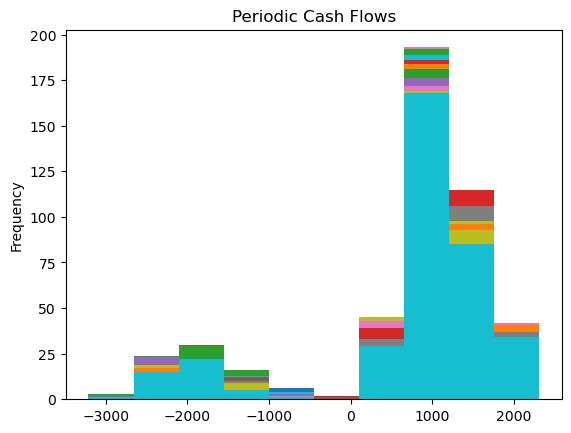

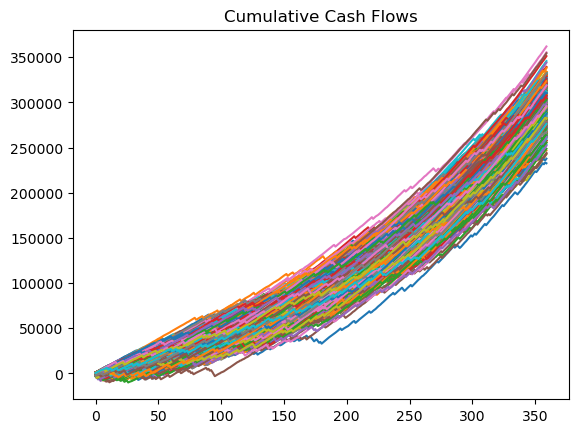

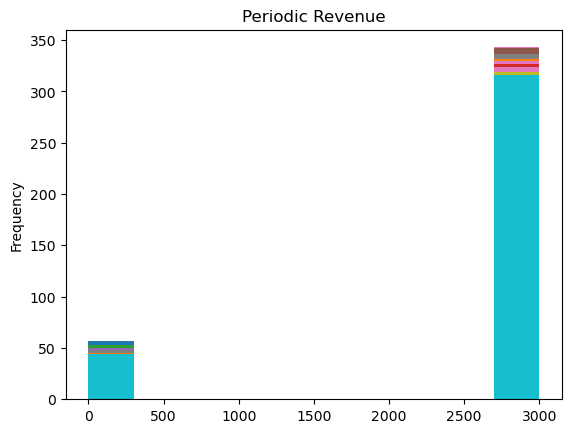

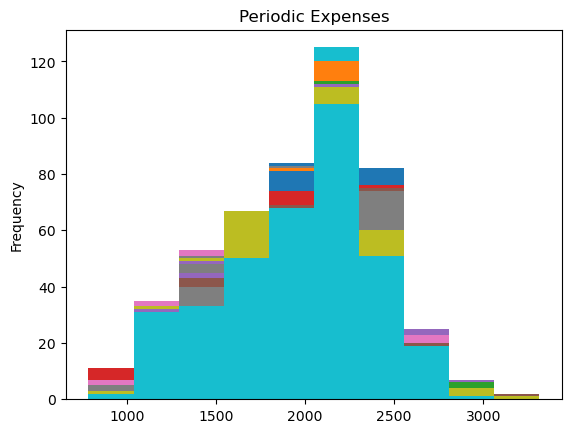

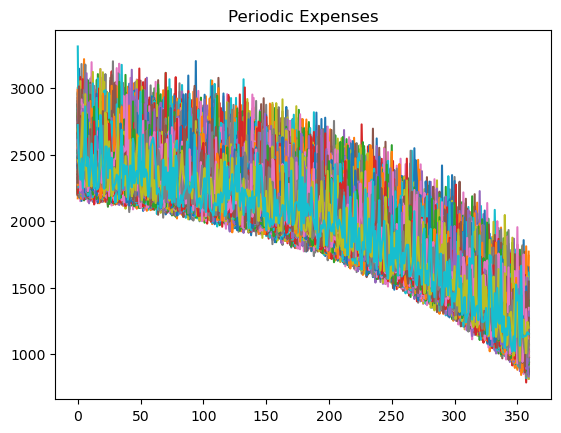

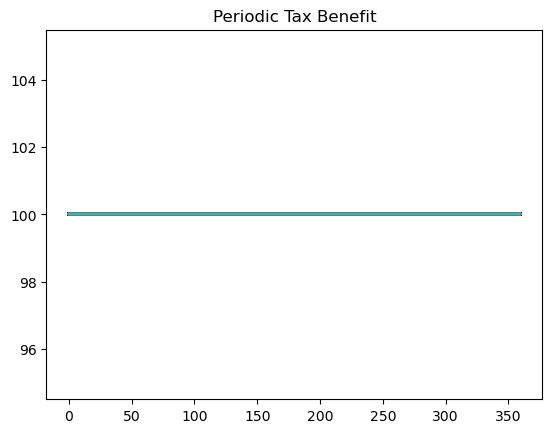

: 

In [35]:
simulation.analyze()

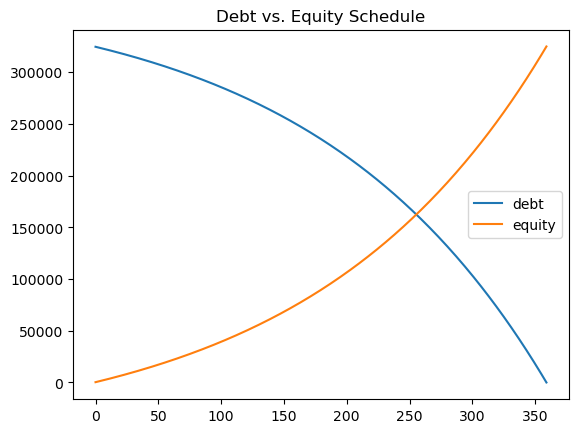

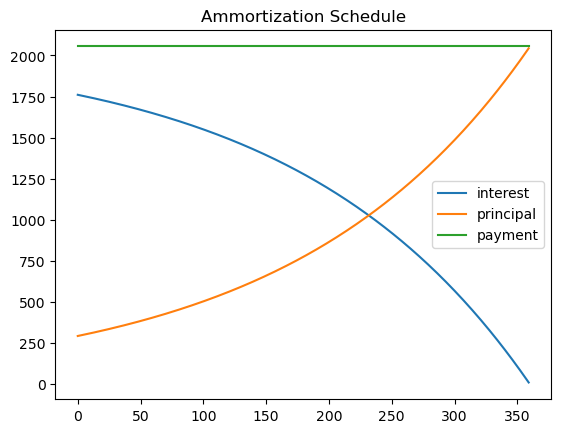

In [95]:
simulation.ammortization_schedule.plot()n
n
n

<Axes: >

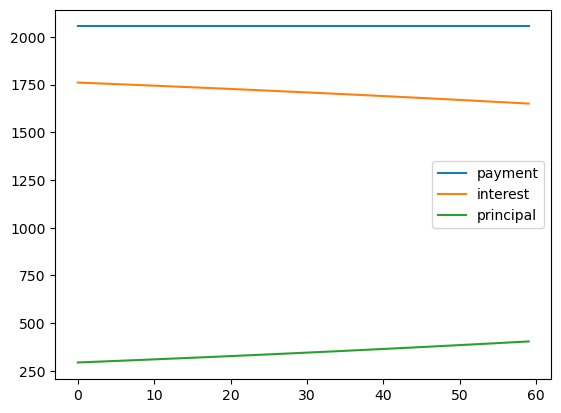

In [768]:
simulation.ammortization_schedule.schedule.head(12*5).iloc[:, :3].plot()

Mean Cash Flow: 172164.24468516564
Min Cash Flow: 85217.55451244334
Max Cash Flow: 235312.38570697026


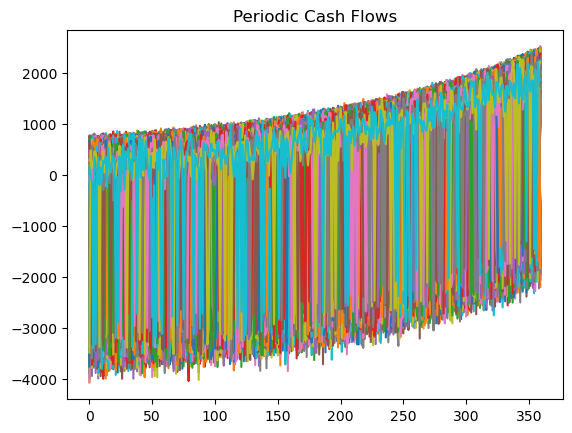

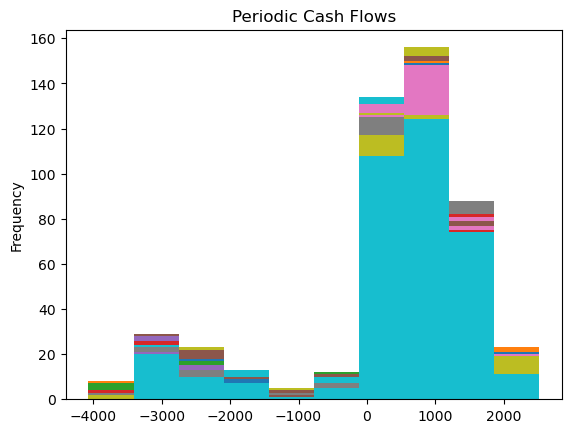

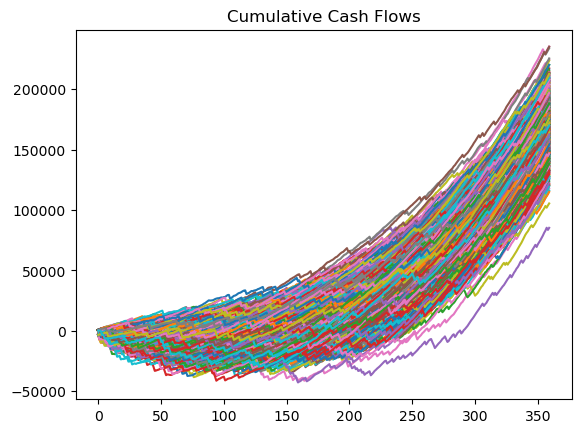

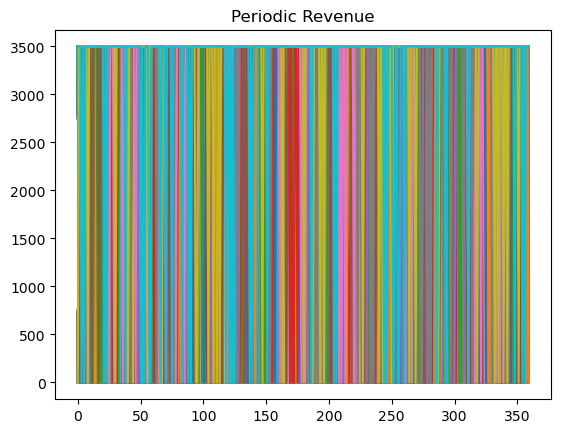

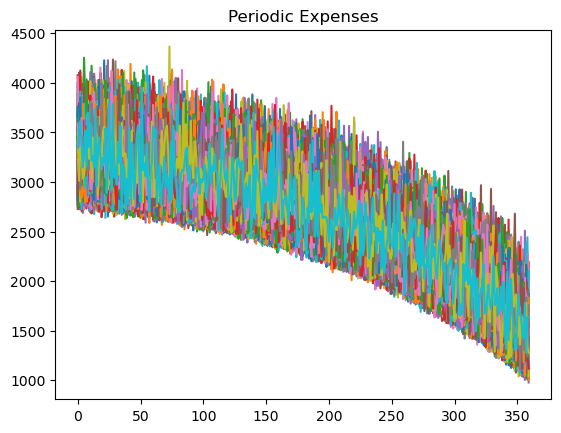

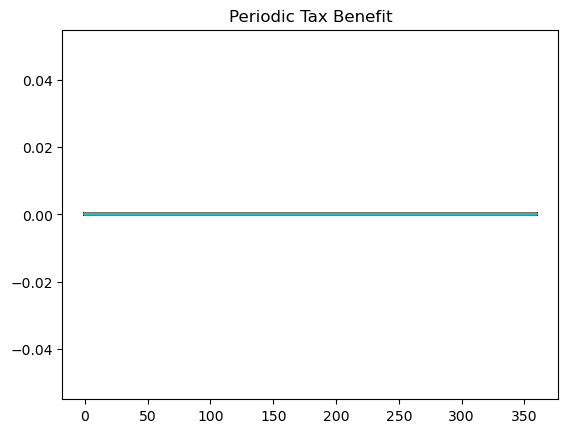

In [774]:
simulation.analyze()